In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def draw(xs, Rs):  ###graphslam3draw
    ##世界の描画##
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111) 
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    
    ##軌跡の描画##
    poses = [xs[s] for s in range(len(hat_xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
    ##R_tの描画##  #追加
    for t in range(1,t_end+1):
        ax.add_patch( sigma_ellipse(xs[t], Rs[t], 3) )
    
    ##描画実行##
    plt.show()

In [3]:
###データの読み込み###
delta = 0.0
xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
us = {}    #制御入力のデータ（ステップ数をキーにして保存）

with open("log.txt") as f:
    for line in f.readlines():
        tmp = line.rstrip().split()
        
        step = float(tmp[1])
        if tmp[0] == "delta":
            delta = float(tmp[1])
        elif tmp[0] == "x": #姿勢のレコードの場合
            xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
        elif tmp[0] == "u": #制御入力の場合
            us[step] = np.array([float(tmp[2]), float(tmp[3])]).T
            
import copy
hat_xs = copy.copy(xs)

In [4]:
##空の精度行列と一次の項のベクトルの準備## 
t_end = len(xs) - 1 #step数（数式中のT）
#t_end = 1

##精度行列の次元を求めて精度行列と一次の項のベクトルの初期化##
dim = (t_end + 1)*3# + len(observed_landmarks)*2
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

##確認##
print(t_end)                           #終了時刻
print(Omega)                        #精度行列
print(xi)                                  #一次の項のベクトル

91
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 

In [5]:
##Ω_0を作る## ###graphslam3omegazero
alpha = 0.001
Sigma_0 = np.diag([0.001**2, 0.001**2, 0.001**2])

Om_0 = np.linalg.inv(Sigma_0) #3x3の精度行列としてΩ0を作る
xi_0 = Om_0.dot(xs[0])

print("Ω0 = ", Om_0)
print("ξ0 =", xi_0)

Ω0 =  [[1000000.       0.       0.]
 [      0. 1000000.       0.]
 [      0.       0. 1000000.]]
ξ0 = [0. 0. 0.]


In [6]:
##Ωxx,ξxxを作る##   ###graphslam3motioninfo
motion_noise_stds = {"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}

def R(t): #R_tを返す
    theta = xs[t-1][2]
    nu, omega = us[t]
#    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
#    if abs(nu) < 1e-5:         nu = 1e-5
        
    st, ct = math.sin(theta), math.cos(theta)
    stw, ctw = math.sin(theta + omega*delta), math.cos(theta + omega*delta)
    A = np.array([[(stw - st)/omega,    -nu/(omega**2)*(stw - st) + nu/omega*delta*ctw],
                                 [(-ctw + ct)/omega, -nu/(omega**2)*(-ctw + ct) + nu/omega*delta*stw],
                                 [0,                                delta]] )
    M = np.diag(
        [motion_noise_stds["nn"]**2*abs(nu)/delta +motion_noise_stds["no"]**2*abs(omega)/delta,
             motion_noise_stds["on"]**2*abs(nu)/delta + motion_noise_stds["oo"]**2*abs(omega)/delta]
    )
    return A.dot(M).dot(A.T) + np.diag([0.01**2, 0.01**2, 0.01**2]) #xyθ方向に誤差を混ぜておく
    #return np.diag([0.1**2, 0.1**2, 0.1**2]) 

def F(t): #F_x_{t-1}を返す（添字注意）
    F = np.array(np.eye(3))
    theta = xs[t-1][2]
    nu, omega = us[t]
#    if abs(omega) < 1e-5: omega = 1e-5 #ゼロにすると式が変わるので避ける
#    if abs(nu) < 1e-5:         nu = 1e-5
    
    F[0, 2] = nu / omega * (math.cos(theta + omega * delta) - math.cos(theta))
    F[1, 2] = nu / omega * (math.sin(theta + omega * delta) - math.sin(theta))
        
    return F

##必要な行列を先に計算##
Rs, Fs, Rinvs = {}, {}, {}
for t in range(1, t_end+1):
    Rs[t] = R(t)
    Rinvs[t] = np.linalg.inv(Rs[t])
    Fs[t-1] = F(t)
    
##各x_{t-1}, x_tペアの精度行列と一次の項のベクトルを作る##
Omxx_ul, Omxx_ur, Omxx_bl, Omxx_br = {}, {}, {}, {} #x_{t-1}とx_tに対する精度行列を保管する辞書
xixx_u, xixx_b = {}, {}

import copy

for t in range(1, t_end+1):
    Omxx_ul[(t-1, t)] = Fs[t-1].T.dot(Rinvs[t]).dot(Fs[t-1])
    Omxx_ur[(t-1, t)] = -Fs[t-1].T.dot(Rinvs[t])
    Omxx_bl[(t-1, t)] = -Rinvs[t].dot(Fs[t-1].T)
    Omxx_br[(t-1, t)] = copy.copy(Rinvs[t])
    
    xixx_b[(t-1, t)] = Rinvs[t].dot(hat_xs[t]- Fs[t-1].dot(xs[t-1])) #下の3行から計算
    xixx_u[(t-1, t)] = - Fs[t-1].T.dot(xixx_b[(t-1, t)])

In [7]:
Omega = np.zeros((dim, dim))
xi = np.zeros((dim, 1))

Omega[0:3, 0:3] += Om_0
xi[0:3, 0] += xi_0

for t in range(1, t_end+1):
    Omega[(t-1)*3:t*3, (t-1)*3:t*3] +=  Omxx_ul[(t-1, t)]
    Omega[(t-1)*3:t*3, t*3:(t+1)*3] +=  Omxx_ur[(t-1, t)]
    Omega[t*3:(t+1)*3, (t-1)*3:t*3] +=  Omxx_bl[(t-1, t)]
    Omega[t*3:(t+1)*3, t*3:(t+1)*3] +=  Omxx_br[(t-1, t)]
    
    xi[(t-1)*3:t*3, 0] += xixx_u[(t-1, t)]
    xi[t*3:(t+1)*3, 0] += xixx_b[(t-1, t)]
    
#xx = np.zeros((dim, 1))
#for t in range(t_end+1):
#    xx[t*3:t*3+3, 0] += xs[t]
#xi = Omega.dot(xx) 

[0.19974625 0.00872111 0.08726646]
[-0.17854806 -0.01706328 -0.00283673]


<IPython.core.display.Javascript object>


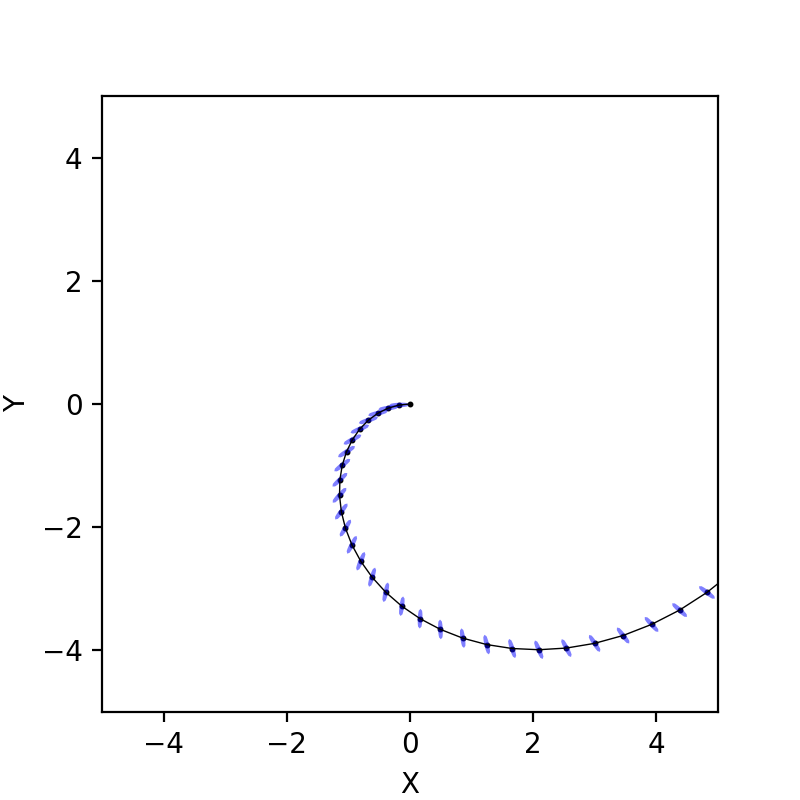

In [8]:
A = Omega[0:(t_end+1)*3 , 0:(t_end+1)*3 ]
b = xi[0:(t_end+1)*3, 0]

#A = Omega[0:6 , 0:6 ]
#b = xi[0:6, 0]

print(hat_xs[1])

c = np.linalg.inv(A).dot(b)
for t in range(1,t_end+1):
    hat_xs[t] = c[t*3:t*3+3]
    
print(hat_xs[1])
    
draw(hat_xs, Rs)

In [9]:
np.linalg.inv(A).dot(b)

array([-5.16145270e-05, -5.98334932e-06, -1.33762825e-05, -1.78548061e-01,
       -1.70632753e-02, -2.83673435e-03, -3.53558305e-01, -6.69459479e-02,
       -3.62975338e-03, -5.20585849e-01, -1.49197207e-01, -3.90258476e-03,
       -6.75627352e-01, -2.62752780e-01, -3.96841387e-03, -8.14772820e-01,
       -4.06075806e-01, -3.90758067e-03, -9.34185505e-01, -5.77154617e-01,
       -3.75497659e-03, -1.03016365e+00, -7.73493314e-01, -3.53584175e-03,
       -1.09922019e+00, -9.92115954e-01, -3.27212424e-03, -1.13816426e+00,
       -1.22958697e+00, -2.98326592e-03, -1.14417818e+00, -1.48204693e+00,
       -2.68606400e-03, -1.11488654e+00, -1.74526171e+00, -2.39449835e-03,
       -1.04841496e+00, -2.01468248e+00, -2.11967699e-03, -9.43436883e-01,
       -2.28551390e+00, -1.86990713e-03, -7.99207946e-01, -2.55278770e+00,
       -1.65087014e-03, -6.15587665e-01, -2.81143895e+00, -1.46587483e-03,
       -3.93049059e-01, -3.05638299e+00, -1.31616349e-03, -1.32677064e-01,
       -3.28259069e+00, -

In [10]:
Fs[0].dot(hat_xs[0])

array([0., 0., 0.])

In [11]:
hat_xs[1]

array([-0.17854806, -0.01706328, -0.00283673])

In [12]:
0.08726646/3.14*180

5.002535923566879

In [13]:
hat_xs[2]

array([-0.3535583 , -0.06694595, -0.00362975])

In [14]:
Fs

{0: array([[ 1.        ,  0.        , -0.00872111],
        [ 0.        ,  1.        ,  0.19974625],
        [ 0.        ,  0.        ,  1.        ]]),
 1: array([[ 1.        ,  0.        , -0.02609696],
        [ 0.        ,  1.        ,  0.19822606],
        [ 0.        ,  0.        ,  1.        ]]),
 2: array([[ 1.        ,  0.        , -0.04327419],
        [ 0.        ,  1.        ,  0.19519725],
        [ 0.        ,  0.        ,  1.        ]]),
 3: array([[ 1.        ,  0.        , -0.06012208],
        [ 0.        ,  1.        ,  0.19068287],
        [ 0.        ,  0.        ,  1.        ]]),
 4: array([[ 1.        ,  0.        , -0.0765124 ],
        [ 0.        ,  1.        ,  0.18471728],
        [ 0.        ,  0.        ,  1.        ]]),
 5: array([[ 1.        ,  0.        , -0.09232042],
        [ 0.        ,  1.        ,  0.17734588],
        [ 0.        ,  0.        ,  1.        ]]),
 6: array([[ 1.        ,  0.        , -0.10742583],
        [ 0.        ,  1.        ,  

In [15]:
c

array([-5.16145270e-05, -5.98334932e-06, -1.33762825e-05, -1.78548061e-01,
       -1.70632753e-02, -2.83673435e-03, -3.53558305e-01, -6.69459479e-02,
       -3.62975338e-03, -5.20585849e-01, -1.49197207e-01, -3.90258476e-03,
       -6.75627352e-01, -2.62752780e-01, -3.96841387e-03, -8.14772820e-01,
       -4.06075806e-01, -3.90758067e-03, -9.34185505e-01, -5.77154617e-01,
       -3.75497659e-03, -1.03016365e+00, -7.73493314e-01, -3.53584175e-03,
       -1.09922019e+00, -9.92115954e-01, -3.27212424e-03, -1.13816426e+00,
       -1.22958697e+00, -2.98326592e-03, -1.14417818e+00, -1.48204693e+00,
       -2.68606400e-03, -1.11488654e+00, -1.74526171e+00, -2.39449835e-03,
       -1.04841496e+00, -2.01468248e+00, -2.11967699e-03, -9.43436883e-01,
       -2.28551390e+00, -1.86990713e-03, -7.99207946e-01, -2.55278770e+00,
       -1.65087014e-03, -6.15587665e-01, -2.81143895e+00, -1.46587483e-03,
       -3.93049059e-01, -3.05638299e+00, -1.31616349e-03, -1.32677064e-01,
       -3.28259069e+00, -

In [16]:
Omega

array([[ 1.00015528e+06, -4.25551799e+02, -4.36019632e+01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.25551799e+02,  1.00988388e+06,  1.00318596e+03, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.36019632e+01,  1.00318596e+03,  1.00024528e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.88387879e+03,  4.25551799e+02,  9.74793032e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.25551799e+02,  1.55275078e+02,  4.27545833e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.74793032e+02,  4.27545833e+01,  2.39601484e+02]])

In [17]:
xi

array([[-3.10353718e+01],
       [ 8.38707253e+01],
       [-3.92443906e+00],
       [-2.97431298e+01],
       [ 1.68273520e+02],
       [ 3.45433929e+01],
       [-5.91397051e+01],
       [ 1.62423579e+02],
       [ 6.90875612e+01],
       [-8.76299617e+01],
       [ 1.52750061e+02],
       [ 1.03631729e+02],
       [-1.14773298e+02],
       [ 1.39376194e+02],
       [ 1.38175898e+02],
       [-1.40144538e+02],
       [ 1.22472687e+02],
       [ 1.72720066e+02],
       [-1.63338831e+02],
       [ 1.02255897e+02],
       [ 2.07264234e+02],
       [-1.83976347e+02],
       [ 7.89855229e+01],
       [ 2.41808403e+02],
       [-2.01706708e+02],
       [ 5.29618181e+01],
       [ 2.76352571e+02],
       [-2.16213135e+02],
       [ 2.45223709e+01],
       [ 3.10896739e+02],
       [-2.27216236e+02],
       [-5.96152786e+00],
       [ 3.45440907e+02],
       [-2.34477419e+02],
       [-3.80888885e+01],
       [ 3.79985076e+02],
       [-2.37801890e+02],
       [-7.14333606e+01],
       [ 4.1

In [18]:
import seaborn

<IPython.core.display.Javascript object>


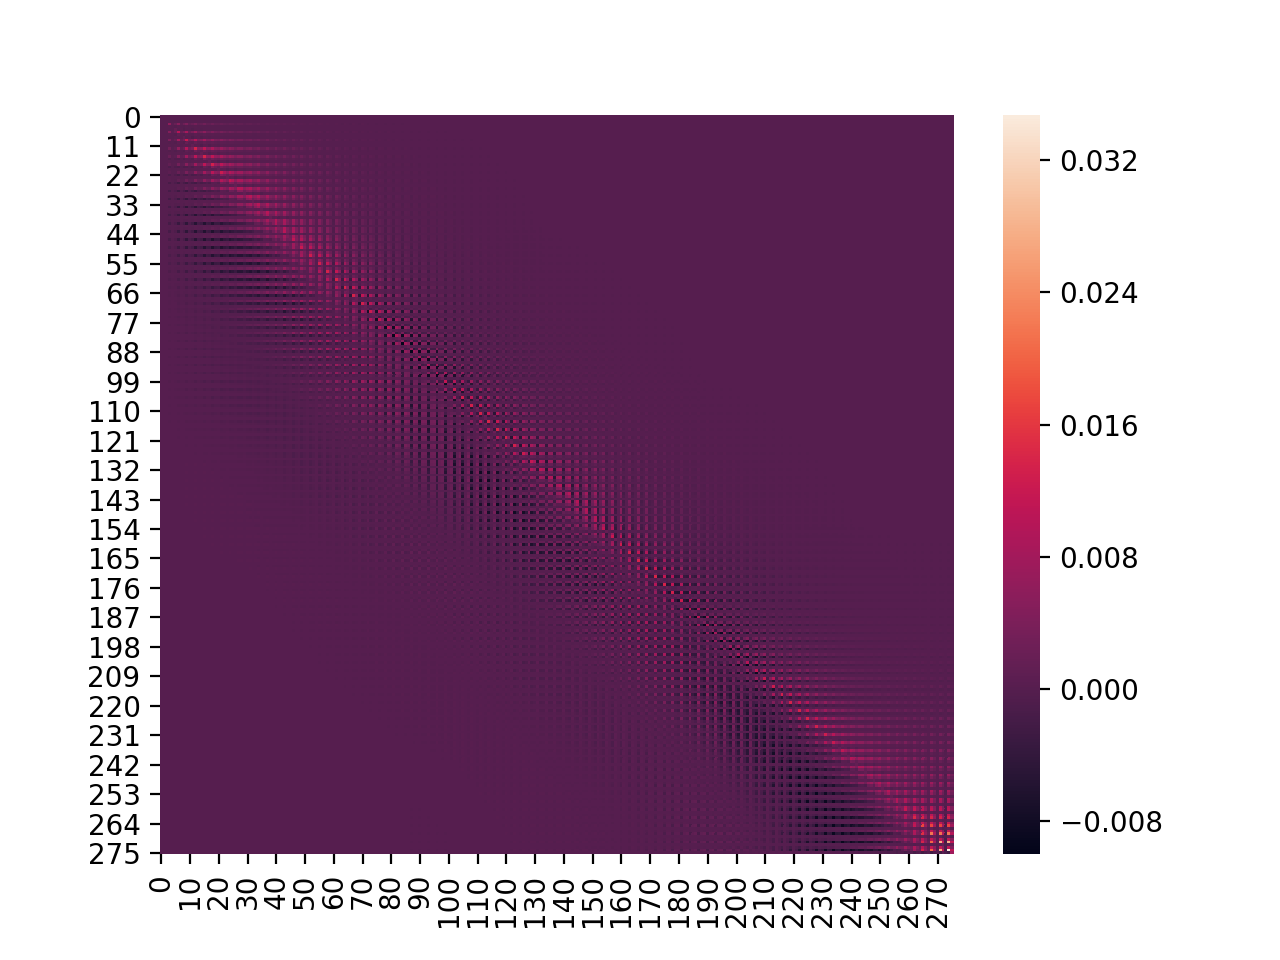

In [19]:
seaborn.heatmap(np.linalg.inv(Omega))
plt.show()

<IPython.core.display.Javascript object>


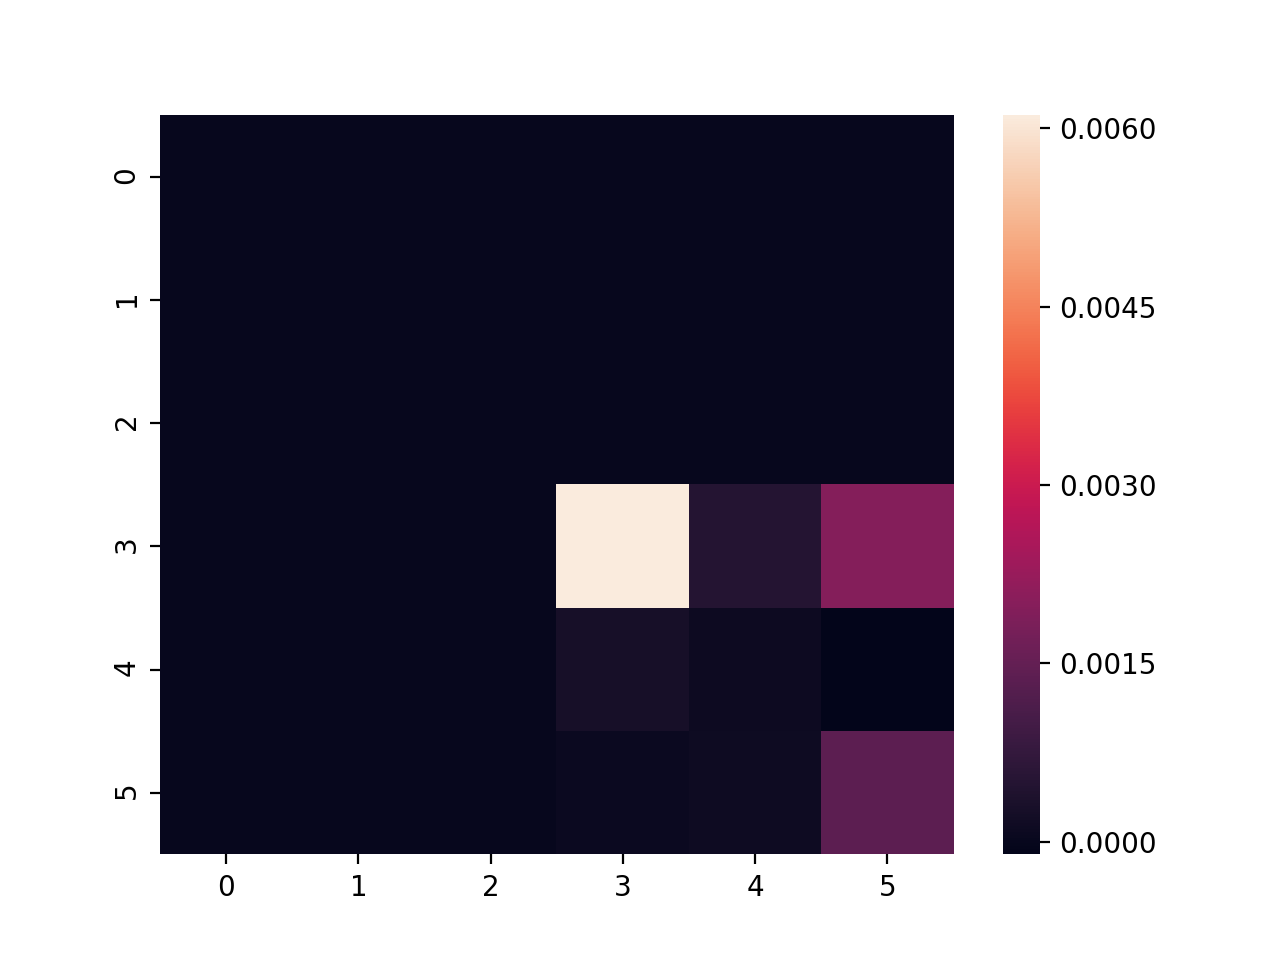

In [20]:
seaborn.heatmap(np.linalg.inv(Omega)[0:6,0:6])
plt.show()

In [21]:
xi

array([[-3.10353718e+01],
       [ 8.38707253e+01],
       [-3.92443906e+00],
       [-2.97431298e+01],
       [ 1.68273520e+02],
       [ 3.45433929e+01],
       [-5.91397051e+01],
       [ 1.62423579e+02],
       [ 6.90875612e+01],
       [-8.76299617e+01],
       [ 1.52750061e+02],
       [ 1.03631729e+02],
       [-1.14773298e+02],
       [ 1.39376194e+02],
       [ 1.38175898e+02],
       [-1.40144538e+02],
       [ 1.22472687e+02],
       [ 1.72720066e+02],
       [-1.63338831e+02],
       [ 1.02255897e+02],
       [ 2.07264234e+02],
       [-1.83976347e+02],
       [ 7.89855229e+01],
       [ 2.41808403e+02],
       [-2.01706708e+02],
       [ 5.29618181e+01],
       [ 2.76352571e+02],
       [-2.16213135e+02],
       [ 2.45223709e+01],
       [ 3.10896739e+02],
       [-2.27216236e+02],
       [-5.96152786e+00],
       [ 3.45440907e+02],
       [-2.34477419e+02],
       [-3.80888885e+01],
       [ 3.79985076e+02],
       [-2.37801890e+02],
       [-7.14333606e+01],
       [ 4.1

In [22]:
xx = np.zeros((dim, 1))
for t in range(t_end+1):
    xx[t*3:t*3+3, 0] += xs[t]
Omega.dot(xx) 

array([[-3.10353718e+01],
       [ 8.38707253e+01],
       [-3.92443906e+00],
       [-2.97431298e+01],
       [ 1.68273520e+02],
       [ 3.45433929e+01],
       [-8.12467296e+01],
       [ 3.30350873e+02],
       [ 5.28980361e+01],
       [-1.60216586e+02],
       [ 4.80179635e+02],
       [ 7.20811019e+01],
       [-2.64537828e+02],
       [ 6.14385378e+02],
       [ 9.20799325e+01],
       [-3.91749452e+02],
       [ 7.29921683e+02],
       [ 1.12875661e+02],
       [-5.39093235e+02],
       [ 8.24098627e+02],
       [ 1.34443357e+02],
       [-7.03563833e+02],
       [ 8.94604040e+02],
       [ 1.56752214e+02],
       [-8.81958975e+02],
       [ 9.39517763e+02],
       [ 1.79765784e+02],
       [-1.07092879e+03],
       [ 9.57319283e+02],
       [ 2.03442257e+02],
       [-1.26702335e+03],
       [ 9.46889284e+02],
       [ 2.27734778e+02],
       [-1.46673779e+03],
       [ 9.07505749e+02],
       [ 2.52591803e+02],
       [-1.66655422e+03],
       [ 8.38835345e+02],
       [ 2.7

In [23]:
xi

array([[-3.10353718e+01],
       [ 8.38707253e+01],
       [-3.92443906e+00],
       [-2.97431298e+01],
       [ 1.68273520e+02],
       [ 3.45433929e+01],
       [-5.91397051e+01],
       [ 1.62423579e+02],
       [ 6.90875612e+01],
       [-8.76299617e+01],
       [ 1.52750061e+02],
       [ 1.03631729e+02],
       [-1.14773298e+02],
       [ 1.39376194e+02],
       [ 1.38175898e+02],
       [-1.40144538e+02],
       [ 1.22472687e+02],
       [ 1.72720066e+02],
       [-1.63338831e+02],
       [ 1.02255897e+02],
       [ 2.07264234e+02],
       [-1.83976347e+02],
       [ 7.89855229e+01],
       [ 2.41808403e+02],
       [-2.01706708e+02],
       [ 5.29618181e+01],
       [ 2.76352571e+02],
       [-2.16213135e+02],
       [ 2.45223709e+01],
       [ 3.10896739e+02],
       [-2.27216236e+02],
       [-5.96152786e+00],
       [ 3.45440907e+02],
       [-2.34477419e+02],
       [-3.80888885e+01],
       [ 3.79985076e+02],
       [-2.37801890e+02],
       [-7.14333606e+01],
       [ 4.1